In [10]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from PIL import Image
from mrcnn.utils import resize_image
import easyocr
from mrcnn.config import Config
from pdf2image import convert_from_bytes
from colabcode import ColabCode
from fastapi import FastAPI,UploadFile, File,Response
from pyngrok import ngrok
import cv2
import numpy as np
from googlesearch import search


ngrok.kill()
Modelpath="/home/rcnn/mask_rcnn_object_0010.h5"

In [2]:

class CustomConfig(Config):
    def __init__(self, num_classes):
        classes_number = num_classes
        super().__init__()
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    STEPS_PER_EPOCH = 500
    VALIDATION_STEPS = 5
    DETECTION_MIN_CONFIDENCE = 0.9

class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


In [3]:
def get_google_links(q_text):
  return list(search(q_text,stop=3))

In [4]:
def load_inference_model(num_classes, model_path):
    inference_config = InferenceConfig(num_classes)

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference",
                              config=inference_config,
                              model_dir=model_path)
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    return model, inference_config
def extract_questions_image(rois,img,factor=2337):
    img_arr=[]
    img2=img
    q_arr=[]
    list_of_links = []
    for i in rois:
        # print(i)
        roi=i
        img=Image.fromarray(img2)
        l = (roi[1])*(factor/512)
        t = roi[0]*(factor/512)
        ri = (roi[3])*(factor/512)
        b = roi[2]*(factor/512)
        img = img.crop((l, t, ri, b))
        #   img = img.crop((0+pad, 0, 1000+pad, 1000))
        # print(roi)
        img=np.asarray(img)
        img_arr.append((img,[t,l,b,ri]))
    img_arr.sort(key = lambda x: x[1][0])
    for i in img_arr:
        text = language.readtext(i[0],paragraph=True)
        s=' '.join([k[1] for k in text])
        # print(s)
        list_of_links.append(get_google_links(s))
        q_arr.append(s)
        visualize.display_images([i[0]], cmap="Blues",cols=1)
    # return img_arr
    print()
    return q_arr,[i[1] for i in img_arr],list_of_links
def input_as_bytes(byte):
    return [np.asarray(i) for i in convert_from_bytes(byte, dpi=150, thread_count=2, grayscale=True, fmt="jpg")]

In [5]:
model, inference_config=load_inference_model(1,Modelpath)
language = easyocr.Reader(['en'])


2022-11-14 10:32:37.599115: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-14 10:32:37.681997: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2592000000 Hz
2022-11-14 10:32:37.682584: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xad43c90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-14 10:32:37.682601: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Loading weights from  /home/rcnn/mask_rcnn_object_0010.h5


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [6]:
cc = ColabCode(port=12000, code=False)
public_url = ngrok.connect(port='12000')

In [7]:
imgtry=cv2.imread("/home/rcnn/dataset/aa04eb5a-8-1.jpg")
imgtry=cv2.cvtColor(imgtry,cv2.COLOR_BGR2RGB)


def final_result_from_nparray(imgtry):
    print("tryshape initial",imgtry.shape)
    factor=imgtry.shape[0]
    imgtry2, window, scale, padding, crop=resize_image(imgtry,max_dim=512)
    results=model.detect([imgtry2], verbose=1)
    r = results[0]
    rois=[]
    for i,j in zip(r['scores'],r['rois']):
        if i>=0.95:
            rois.append(j)
    imgtry, window, scale, padding, crop=resize_image(imgtry,max_dim=factor)
    return extract_questions_image(rois,imgtry,factor)
# final_result_from_nparray(imgtry)

In [11]:
app = FastAPI()
@app.get("/")
async def read_root(response: Response):
  response.headers["Access-Control-Allow-Origin"] = "*"
  return "corpp_dic"

@app.post("/uploadpaper")
async def upload_paper(response: Response,file: bytes=File(...)):
  response.headers["Access-Control-Allow-Origin"] = "*"
  papers_array = input_as_bytes(bytearray(file))
  corpp_dic={}
  counter=0
  for paper in papers_array:
    res=final_result_from_nparray(paper)
    corpp_dic[str(counter)]={'q_arr':res[0],'rois':res[1],'ans_arr':res[1]}
    counter+=1
  return corpp_dic


Public URL: NgrokTunnel: "https://dec6-27-255-222-25.ngrok.io" -> "http://localhost:12000"


INFO:     Started server process [1632]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)


tryshape initial (1753, 1240, 3)
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


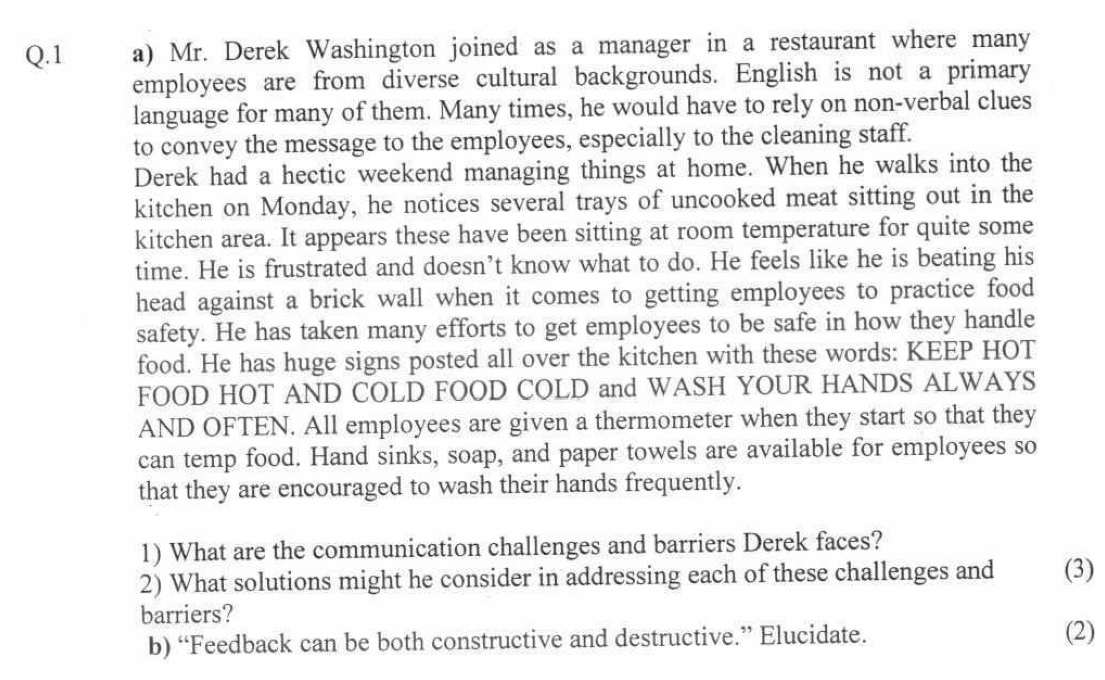

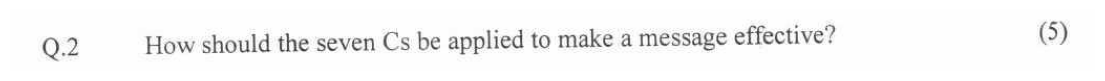

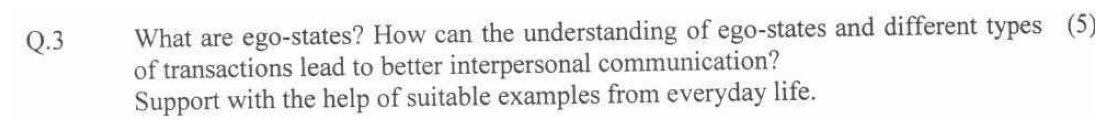

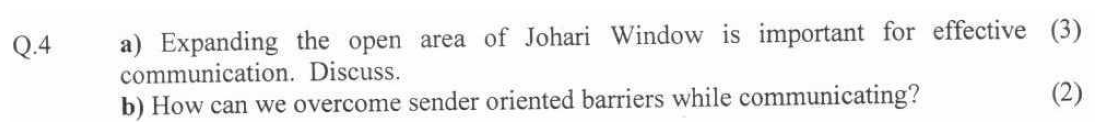

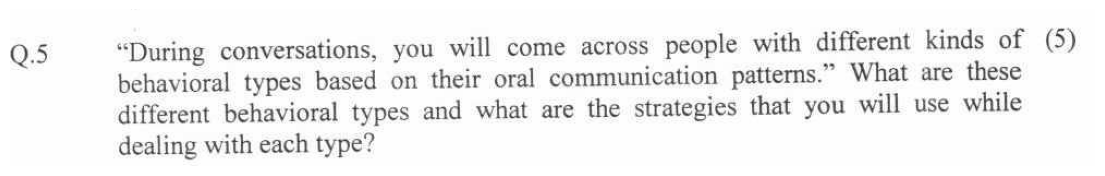


INFO:     27.255.222.25:0 - "POST /uploadpaper HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET / HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     2409:4055:695:3478:1904:787a:284b:d7e3:0 - "GET /openapi.json HTTP/1.1" 200 OK
tryshape initial (1753, 1240, 3)
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
ancho

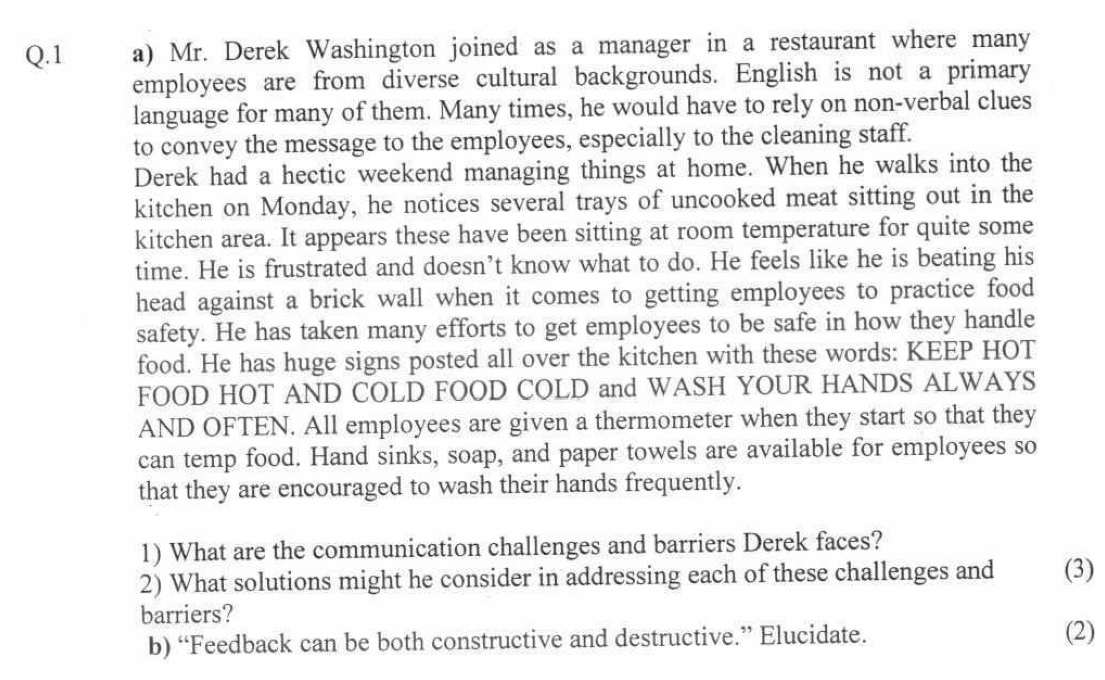

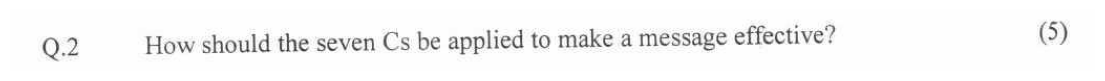

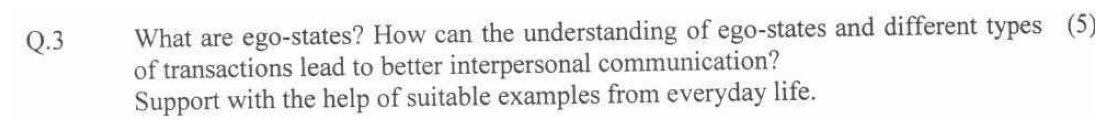

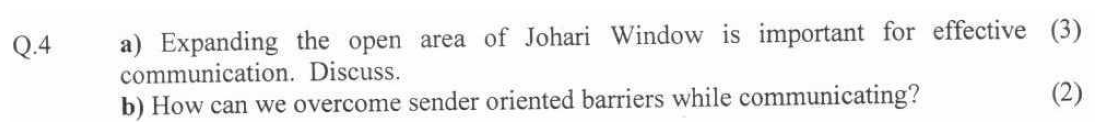

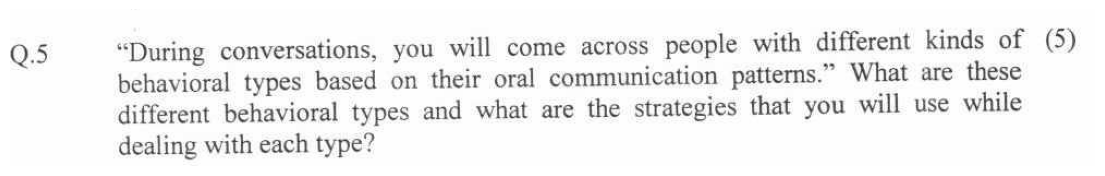


INFO:     27.255.222.25:0 - "POST /uploadpaper HTTP/1.1" 200 OK
tryshape initial (1753, 1240, 3)
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


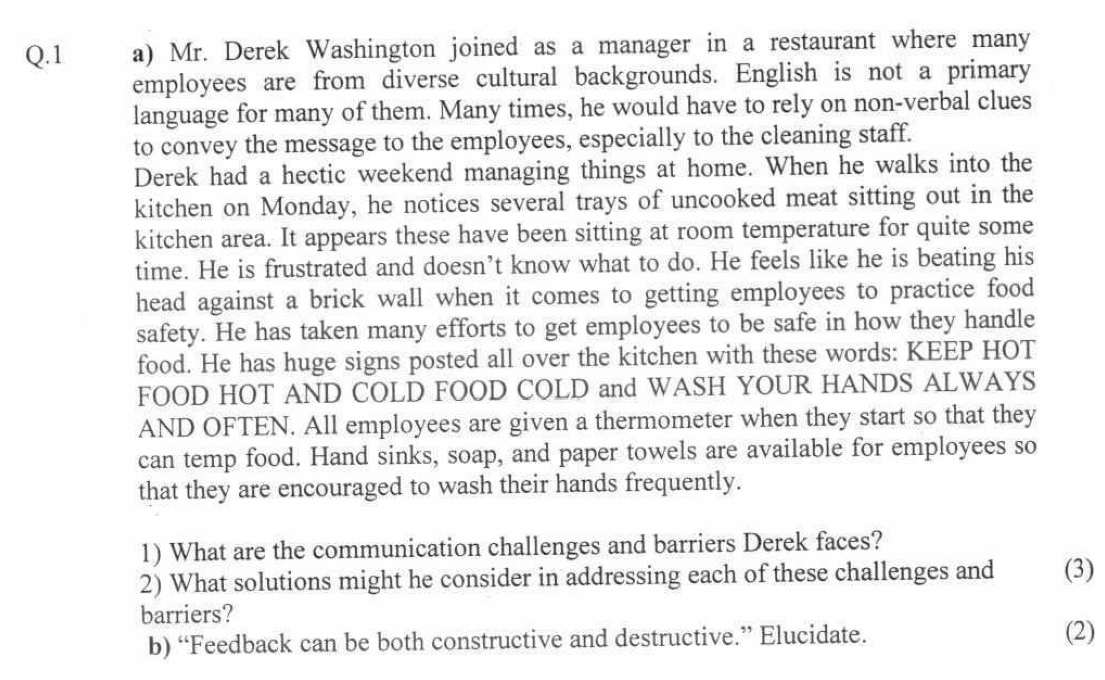

In [ ]:
cc.run_app(app=app)
